# AHE Datathon 2024

# 1. Libraries

In [1]:
import gc
import os
import re
import time
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import Tuple

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, BaseCrossValidator, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix, log_loss

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

warnings.filterwarnings(action="ignore")

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# 2. Utils

In [2]:
def determine_coeffs(df):
    label_counts = df.groupby("label").size()
    inverse_freq = {k: 1 / v for k, v in label_counts.items()}
    normalized_coeffs = {
        k: v / sum(inverse_freq.values()) for k, v in inverse_freq.items()
    }
    return normalized_coeffs


def fix_col_names(dataframe: pd.DataFrame) -> pd.DataFrame:

    df_ = dataframe.copy()
    translation = lambda x: x.translate(x.maketrans("ÜüÖöİıĞğŞşÇç", "UuOoIiGgSsCc"))
    df_.columns = df_.columns.map(lambda x: translation(x).lower().replace(" ", "_"))
    df_ = df_.rename(
        columns={col: re.sub(r"[^A-Za-z0-9_]+", "", col) for col in df_.columns}
    )

    return df_


def rare_encode(
    dataframe: pd.DataFrame, feature: str, freq_limit: int = 70
) -> pd.DataFrame:

    df_ = dataframe.copy()
    most_common_cats = (
        df_[feature]
        .value_counts()[df_[feature].value_counts() > freq_limit]
        .keys()
        .tolist()
    )

    for cat in most_common_cats:
        df_[f"is_{feature}_{cat}"] = df_[feature].apply(lambda x: 1 if x == cat else 0)

    return df_.drop(columns=[feature], axis=1).reset_index(drop=True)


def plot_confusion_matrix(cm, classes, title) -> None:
    plt.imshow(cm, interpolation="nearest", cmap="Blues")
    plt.title(title, size=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], ".0f"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.grid(False)
    plt.show()


def clf_trainer(
    model: BaseEstimator,
    X: pd.DataFrame,
    X_test: pd.DataFrame,
    y: pd.Series,
    cv: BaseCrossValidator,
    groups: pd.Series = None,
    train_params: dict = dict(),
    plot_importances: bool = False,
    eval_metric: str = "roc_auc",
) -> dict:

    report = dict()
    if plot_importances == True:
        features = X.columns.tolist()
        feat_imp_df = pd.DataFrame({"feature": features})

    if y.nunique() == 2:
        train_oof_preds = np.zeros(shape=(X.shape[0]))
        test_oof_preds = np.zeros(shape=(X_test.shape[0]))
    else:
        train_oof_preds = np.zeros(shape=(X.shape[0], y.nunique()))
        test_oof_preds = np.zeros(shape=(X_test.shape[0], y.nunique()))

    fitted_models = list()
    fold_scores = list()
    if groups is not None:
        split_fn = cv.split(X=X, y=y, groups=groups)
        n_splits = cv.get_n_splits(X=X, y=y, groups=groups)
    else:
        split_fn = cv.split(X=X, y=y)
        n_splits = cv.get_n_splits(X=X, y=y)
    print(f"n folds: {n_splits}")

    for idx, (train_idx, val_idx) in enumerate(split_fn):
        print(f"| Fold {idx+1} |".center(90, "="))
        start_time = time.time()

        X_train, y_train = X.loc[train_idx], y.loc[train_idx]
        X_val, y_val = X.loc[val_idx], y.loc[val_idx]

        print(f"train: {X_train.shape}")
        print(f"val: {X_val.shape}")

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **train_params)

        fitted_models.append(model)
        val_pred = model.predict(X_val)
        test_pred = model.predict(X_test)

        if y.nunique() == 2:
            val_pred_proba = model.predict_proba(X_val)[:, 1]
            test_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            val_pred_proba = model.predict_proba(X_val)
            test_pred_proba = model.predict_proba(X_test)

        test_oof_preds += test_pred_proba / n_splits
        train_oof_preds[val_idx] = val_pred_proba

        if eval_metric == "roc_auc":
            val_score = roc_auc_score(y_val, val_pred_proba)
        elif eval_metric == "log_loss":
            val_score = log_loss(y_val, val_pred_proba)
        elif eval_metric == "f1":
            if y.nunique() == 2:
                val_score = f1_score(y_val, val_pred)
            else:
                val_score = f1_score(y_val, val_pred, average="weighted")
        else:
            val_score = accuracy_score(y_val, val_pred)
        fold_scores.append(val_score)

        if plot_importances == True:
            feat_imp_df = feat_imp_df.merge(
                pd.DataFrame(
                    {
                        "feature": features,
                        f"fold_{idx+1}_feat_imp": model.feature_importances_,
                    }
                ),
                on=["feature"],
                how="left",
            )

        end_time = time.time()
        elapsed = end_time - start_time

        print(f"Fold {eval_metric}: {val_score:.5f}")
        print(f"Elapsed: {elapsed:.2f} seconds\n")

    print("=" * 90)
    print(f"CV: {np.mean(fold_scores):.5f}")

    report["fitted_models"] = fitted_models
    report["train_preds"] = train_oof_preds
    report["test_preds"] = test_oof_preds
    report["fold_scores"] = fold_scores

    if plot_importances == True:
        feat_imp_df["avg_importance"] = feat_imp_df.iloc[:, 1:].mean(axis=1)
        plt.figure(figsize=(12, 10))
        sns.barplot(
            data=feat_imp_df.sort_values(by="avg_importance", ascending=False).iloc[
                :50
            ],
            x="avg_importance",
            y="feature",
            color="royalblue",
            width=0.75,
        )
        plt.title("Average Feature Importances for All Folds", size=12)
        plt.show()

        report["feature_importances"] = feat_imp_df

    return report


# 3. Configuration

In [3]:
class config:
    root = "/kaggle/input/anadolu-hayat-emeklilik-datathon-2024"
    train_path = os.path.join(root, "train.csv")
    test_path = os.path.join(root, "test.csv")
    sample_submission_path = os.path.join(root, "sample_submission.csv")
    urun_ozellikleri_path = os.path.join(root, "Urun Ozellikleri.xlsx")
    seed = 42
    thr_opt = True

# 4. Loading Data

In [4]:
train_df = pd.read_csv(config.train_path)
test_df = pd.read_csv(config.test_path)

train_df.head()

,MUSTERI_ID,LABEL,FLAG,PP_CINSIYET,PP_YAS,PP_MESLEK,PP_MUSTERI_SEGMENTI,PP_UYRUK,IL,SORU_YATIRIM_KARAKTERI_CVP,...,HU11,HU12,HU13,HU14,HU15,HU16,HU17,HU18,HU19,AKTIF_ILK_POLICE_RG
0,61921038d5c39a821cfed2e5e3ad88740decd1fbd6f34b...,UA,HAZIRAN,2,505,Öğretmen,105,1,34,NaN,...,0,0,0,0,0,0,0,0,0,9
1,8cd400d3897e5ff130e8e942ee1906d17531a8253d26a4...,UA,HAZIRAN,2,889,Emekli (Sosyal Güvenlik Kurumu Bilinmiyor),102,1,20,NaN,...,0,0,0,0,0,0,0,0,0,11
2,6af95ba9ebe2362a0b31b4443fb2405b11d588780c01ad...,HU19,HAZIRAN,2,578,Muhasebe,104,1,6,Yetkin,...,0,1,0,0,0,0,0,0,0,66
3,fe33e7873368d603d2a49a982619e8d61a964d7a0ef68e...,UA,MAYIS,2,648,Diğer,106,1,34,NaN,...,0,0,0,0,0,0,0,0,0,111
4,aae8411e2c335e94922290314abe1fcc81044e8071e1c8...,UA,EYLUL,2,487,İşçi,103,1,77,NaN,...,0,0,0,0,0,0,0,0,0,90


In [5]:
urun_ozellikler = pd.read_excel(config.urun_ozellikleri_path)

urun_ozellikler.head()

,Ürün,Branş,Grup/Ferdi,Kredili/Kredisiz,Taşınan Teminat,Biriktiren/ Koruma,Sigortas Süresi,Yenileme Fonksiyonu,Yaş Gereksinimi
0,BU01,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
1,BU02,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,18-25
2,BU03,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
3,BU04,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN
4,BU05,Bireysel Emeklilik,Ferdi,Krediden bağımsız,NaN,Biriktiren,Uzun Süreli,NaN,NaN


# 5. Feature Engineering

In [6]:
%%time

target_mapping = {
    "UA": 0,
    "HU14": 1,
    "HU07": 1,
    "HU06": 1,
    "HU19": 1,
    "HU12": 1,
    "HU11": 1,
    "HU15": 1,
}
flag_mapping = {
    "MAYIS": 1,
    "HAZIRAN": 2,
    "TEMMUZ": 3,
    "AGUSTOS": 4,
    "EYLUL": 5,
    "EKIM": 6,
    "KASIM": 7,
    "ARALIK": 8,
}

train_df["binary_label"] = train_df["LABEL"].apply(lambda x: target_mapping[x])

df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

df.drop(columns=["MUSTERI_ID"], axis=1, inplace=True)

bu_cols = [col for col in df.columns if col[:2] == "BU"]
hu_cols = [col for col in df.columns if col[:2] == "HU"]

odeme_tutar_cols = [f"ODEME_TUTAR_{i}" for i in range(12)]
vade_tutar_cols = [f"VADE_TUTAR_{i}" for i in range(12)]

df["product_bu_sum"] = df[bu_cols].sum(axis=1)
df["product_hu_sum"] = df[hu_cols].sum(axis=1)

product_fields = [
    "Branş ",
    "Grup/Ferdi",
    "Kredili/Kredisiz",
    "Biriktiren/ Koruma",
    "Sigortas Süresi ",
]
for f in product_fields:
    for i in urun_ozellikler[f].unique():
        if i not in ["Kredi süresi ile uyumlu "]:
            products = (
                urun_ozellikler.loc[urun_ozellikler[f] == i, "Ürün "].unique().tolist()
            )
            products = [col for col in train_df.columns if col in products]
            df[f"product_{f}_{i}_sum"] = df[products].sum(axis=1)

df["FLAG"] = df["FLAG"].apply(lambda x: flag_mapping[x])
df["PP_YAS"] = df["PP_YAS"] / 12
df["PP_CINSIYET"] = df["PP_CINSIYET"].apply(lambda x: 1 if x == 2 else 0)

df.loc[df["SORU_COCUK_SAYISI_CVP"] == 3000.0, "SORU_COCUK_SAYISI_CVP"] = np.nan

df.loc[
    df["PP_MESLEK"].isin(
        ["Yazılımcı", "Yazılım Geliştirme Uzmanı", "Yazılımcı/Programcı/Analist"]
    ),
    "PP_MESLEK",
] = "Yazılımcı"
df.loc[
    df["PP_MESLEK"].isin(
        [
            "Emekli (Sosyal Güvenlik Kurumu Bilinmiyor)",
            "SSK-Sosyal Sigortalar Kurumu Emeklileri",
            "Emekli Sandığı Emeklileri",
            "Bağkur Emeklileri",
            "Emekli",
            "Emekli (Vakıf,Sandık v.b.)",
        ]
    ),
    "PP_MESLEK",
] = "Emekli"
df.loc[df["PP_MESLEK"] == "Çalışmıyor", "PP_MESLEK"] = "İşsiz"
df.loc[df["PP_MESLEK"] == "Müfettiş/Denetçi", "PP_MESLEK"] = "Denetçi"
df.loc[df["PP_MESLEK"] == "Üniversite Öğrencisi", "PP_MESLEK"] = "Öğrenci"
df.loc[df["PP_MESLEK"] == "Satış/Pazarlama Çalışanı", "PP_MESLEK"] = "Satış"
df.loc[df["PP_MESLEK"] == "Teknisyen/Tekniker", "PP_MESLEK"] = "Teknisyen"
df.loc[df["PP_MESLEK"] == "Finans Sektörü Çalışan", "PP_MESLEK"] = "Finans"
df.loc[df["PP_MESLEK"] == "Medya Mensubu", "PP_MESLEK"] = "Medya"
df.loc[df["PP_MESLEK"].isin(["Şair", "Yazar"]), "PP_MESLEK"] = "Sanatçı"
df["PP_MESLEK"].fillna("Bilinmiyor", inplace=True)

df["SORU_RG1"] = df[
    ["SORU_MEDENI_HAL_RG", "SORU_EGITIM_RG", "SORU_GELIR_RG", "SORU_COCUK_SAYISI_RG"]
].mean(axis=1)
df = df.drop(
    columns=[
        "SORU_MEDENI_HAL_RG",
        "SORU_EGITIM_RG",
        "SORU_GELIR_RG",
        "SORU_COCUK_SAYISI_RG",
    ],
    axis=1,
)
df = df.rename(
    columns={"SORU_YATIRIM_KARAKTERI_RG": "SORU_RG2", "AKTIF_ILK_POLICE_RG": "SORU_RG3"}
)

df["vade_odeme_diff_mean"] = pd.concat(
    [
        (df[[i, j]].diff(axis=1).iloc[:, 1]).astype(int)
        for i, j in zip(vade_tutar_cols, odeme_tutar_cols)
    ],
    axis=1,
).mean(axis=1)
df["vade_odeme_diff_max"] = pd.concat(
    [
        (df[[i, j]].diff(axis=1).iloc[:, 1]).astype(int)
        for i, j in zip(vade_tutar_cols, odeme_tutar_cols)
    ],
    axis=1,
).max(axis=1)
df["vade_odeme_diff_min"] = pd.concat(
    [
        (df[[i, j]].diff(axis=1).iloc[:, 1]).astype(int)
        for i, j in zip(vade_tutar_cols, odeme_tutar_cols)
    ],
    axis=1,
).min(axis=1)
df["vade_odeme_diff_std"] = pd.concat(
    [
        (df[[i, j]].diff(axis=1).iloc[:, 1]).astype(int)
        for i, j in zip(vade_tutar_cols, odeme_tutar_cols)
    ],
    axis=1,
).std(axis=1)

df["getiri_anapara_ratio"] = df["GETIRI"] / df["ANAPARA"]
df["getiri_anapara_diff"] = df["ANAPARA"] - df["GETIRI"]

df.loc[df["SORU_GELIR_CVP"] == "1,5", "SORU_GELIR_CVP"] = 1.5
df.loc[df["SORU_GELIR_CVP"] == "1,2", "SORU_GELIR_CVP"] = 1.2
df.loc[df["SORU_GELIR_CVP"] == "1,6", "SORU_GELIR_CVP"] = 1.6
df.loc[df["SORU_GELIR_CVP"] == "1,65", "SORU_GELIR_CVP"] = 1.65
df.loc[df["SORU_GELIR_CVP"] == "4,5", "SORU_GELIR_CVP"] = 4.5
df.loc[df["SORU_GELIR_CVP"] == "1,3", "SORU_GELIR_CVP"] = 1.3
df.loc[df["SORU_GELIR_CVP"] == "1,13", "SORU_GELIR_CVP"] = 1.13
df.loc[df["SORU_GELIR_CVP"] == "2,5", "SORU_GELIR_CVP"] = 2.5
df.loc[df["SORU_GELIR_CVP"] == "1,1", "SORU_GELIR_CVP"] = 1.1
df.loc[df["SORU_GELIR_CVP"] == "1,4", "SORU_GELIR_CVP"] = 1.4
df.loc[df["SORU_GELIR_CVP"] == "3,5", "SORU_GELIR_CVP"] = 3.5
df.loc[df["SORU_GELIR_CVP"] == "1,7", "SORU_GELIR_CVP"] = 1.7
df.loc[df["SORU_GELIR_CVP"] == "1,45", "SORU_GELIR_CVP"] = 1.45
df.loc[df["SORU_GELIR_CVP"] == "1,25", "SORU_GELIR_CVP"] = 1.25
df.loc[df["SORU_GELIR_CVP"] == "4,8", "SORU_GELIR_CVP"] = 4.8
df.loc[df["SORU_GELIR_CVP"] == "764,3", "SORU_GELIR_CVP"] = 764.3
df.loc[df["SORU_GELIR_CVP"] == "2,6", "SORU_GELIR_CVP"] = 2.6
df.loc[df["SORU_GELIR_CVP"] == "1,16", "SORU_GELIR_CVP"] = 1.16
df.loc[df["SORU_GELIR_CVP"] == "1188,92", "SORU_GELIR_CVP"] = 1188.92
df.loc[df["SORU_GELIR_CVP"] == "1,98", "SORU_GELIR_CVP"] = 1.98
df.loc[df["SORU_GELIR_CVP"] == "1,9", "SORU_GELIR_CVP"] = 1.9
df.loc[df["SORU_GELIR_CVP"] == "4,1", "SORU_GELIR_CVP"] = 4.1
df.loc[df["SORU_GELIR_CVP"] == "7,5", "SORU_GELIR_CVP"] = 7.5
df["SORU_GELIR_CVP"] = df["SORU_GELIR_CVP"].astype("float32")

df.loc[df["SORU_GELIR_CVP"] < 3000, "SORU_GELIR_CVP"] = np.nan
df.loc[df["SORU_GELIR_CVP"] > 100000, "SORU_GELIR_CVP"] = np.nan

df = df.drop(
    columns=[
        "SON_AY_KATKI_ADET",
        "SON_AY_KATKI_MIKTARI",
        "SON_CEYREK_KATKI_MIKTARI",
        "SON_CEYREK_KATKI_ADET",
        "SON_SENE_KATKI_MIKTARI",
        "SON_SENE_KATKI_ADET",
        "SORU_YATIRIM_KARAKTERI_CVP",
        "SORU_RG2",
        "SORU_RG1",
    ],
    axis=1,
)

df = fix_col_names(df)

cat_features = [
    "pp_musteri_segmenti",
    "pp_uyruk",
    "il",
    "soru_egitim_cvp",
    "pp_meslek",
    "soru_medeni_hal_cvp",
    "pp_meslek",
]

for col in cat_features:
    df[col] = df[col].astype("str").astype("category")

df = df.reset_index(drop=True)
print(f"shape: {df.shape}")
df.head()

shape: (1048350, 104)
CPU times: user 17.3 s, sys: 3.42 s, total: 20.7 s
Wall time: 20.7 s


,label,flag,pp_cinsiyet,pp_yas,pp_meslek,pp_musteri_segmenti,pp_uyruk,il,soru_medeni_hal_cvp,soru_egitim_cvp,...,product_biriktiren_koruma_biriktiren_sum,product_biriktiren_koruma_koruma__sum,product_sigortas_suresi__uzun_sureli_sum,product_sigortas_suresi__yillik_sum,vade_odeme_diff_mean,vade_odeme_diff_max,vade_odeme_diff_min,vade_odeme_diff_std,getiri_anapara_ratio,getiri_anapara_diff
0,UA,2,1,42.083333,Öğretmen,105,1,34.0,Single,(Diğer),...,1,0,1,0,0.000000,0,0,0.000000,0.049736,2522
1,UA,2,1,74.083333,Emekli,102,1,20.0,Married,İlköğretim,...,2,0,2,0,159.500000,1914,0,552.524208,1.197395,-12425
2,HU19,2,1,48.166667,Muhasebe,104,1,6.0,Single,Lisans,...,2,1,2,1,0.000000,0,0,0.000000,0.700205,6874
3,UA,1,1,54.000000,Diğer,106,1,34.0,Married,Lise,...,1,0,1,0,-395.333333,-306,-574,131.954078,2.792135,-319
4,UA,5,1,40.583333,İşçi,103,1,77.0,Married,Lisans,...,1,0,1,0,-273.916667,0,-459,190.467587,0.835269,227


In [7]:
df["label"].value_counts()

label
UA      832770
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

In [8]:
df["binary_label"].value_counts()

binary_label
0.0    832770
1.0     19949
Name: count, dtype: int64

# 6. First Stage Model - Binary Classification

In [9]:
X = (
    df.loc[df["binary_label"].notnull()]
    .drop(columns=["binary_label", "label"], axis=1)
    .copy()
)
y = df.loc[df["binary_label"].notnull(), "binary_label"].copy()
X_test = (
    df.loc[df["binary_label"].isnull()]
    .drop(columns=["binary_label", "label"], axis=1)
    .copy()
)

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

n folds: 10
========================================| Fold 1 |========================================
train: (767447, 102)
val: (85272, 102)
0:	learn: 0.0222720	test: 0.0226044	best: 0.0226044 (0)	total: 6.5s	remaining: 9h 1m 58s
200:	learn: 0.2241650	test: 0.2216517	best: 0.2216517 (200)	total: 22.2s	remaining: 8m 49s
400:	learn: 0.2759471	test: 0.2614754	best: 0.2616207 (365)	total: 37.9s	remaining: 7m 14s
600:	learn: 0.3019392	test: 0.2844480	best: 0.2851389 (599)	total: 53.6s	remaining: 6m 32s
800:	learn: 0.3202374	test: 0.2932692	best: 0.2954363 (793)	total: 1m 9s	remaining: 6m 3s
1000:	learn: 0.3372088	test: 0.2980579	best: 0.2998810 (969)	total: 1m 25s	remaining: 5m 39s
1200:	learn: 0.3502697	test: 0.3019314	best: 0.3048444 (1146)	total: 1m 40s	remaining: 5m 18s
1400:	learn: 0.3624428	test: 0.3078131	best: 0.3102907 (1334)	total: 1m 56s	remaining: 4m 59s
1600:	learn: 0.3748231	test: 0.3145980	best: 0.3148438 (1580)	total: 2m 12s	remaining: 4m 41s
1800:	learn: 0.3875936	test: 0.

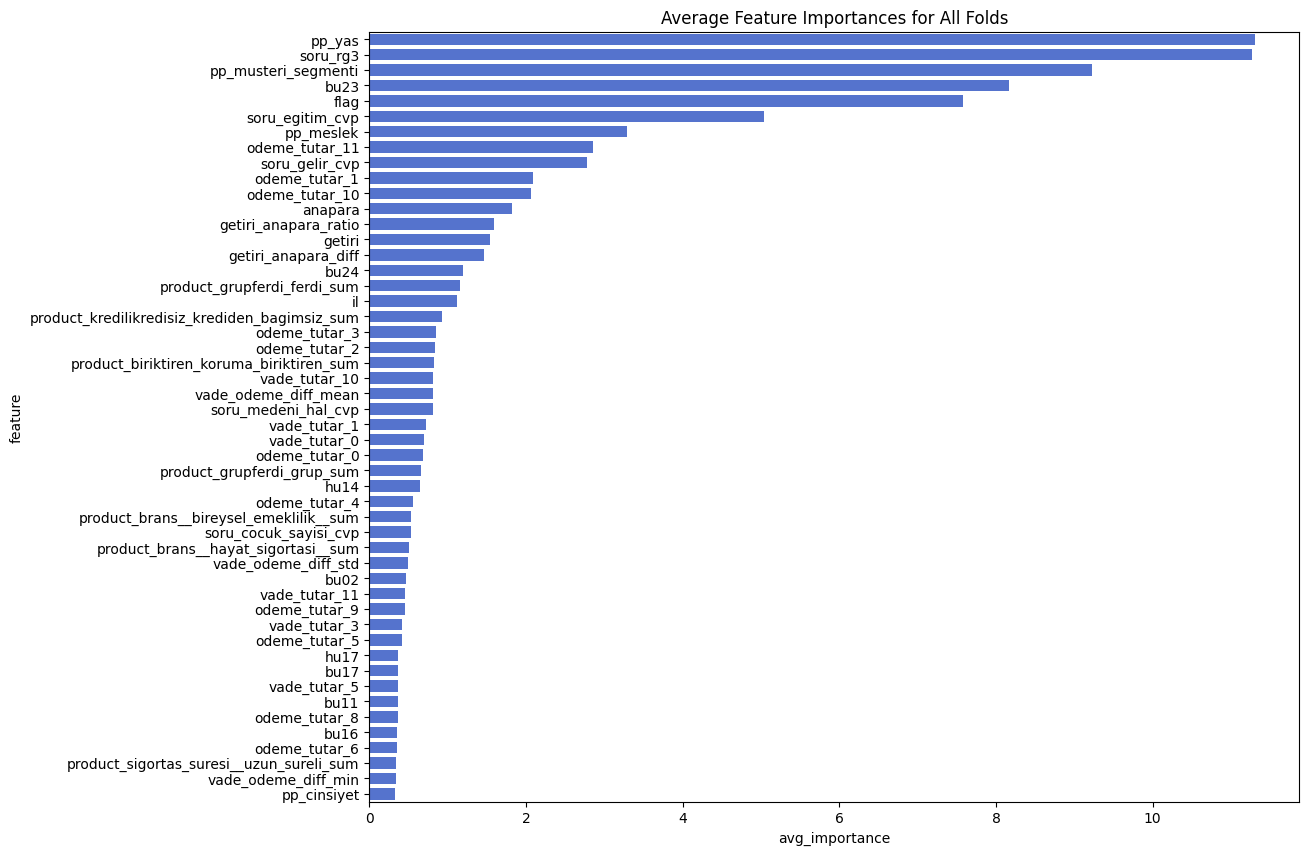

In [10]:
first_stage_model = cb.CatBoostClassifier(
    **{
        "iterations": 5000,
        "allow_writing_files": False,
        "eval_metric": "F1",
        "custom_loss": "F1",
        "max_depth": 8,
        "learning_rate": 0.042,
        "random_state": config.seed,
        "task_type": "GPU",
        "cat_features": cat_features,
    }
)


first_stage_train_params = {"verbose": 200, "early_stopping_rounds": 200}

first_stage_output = clf_trainer(
    model=first_stage_model,
    X=X,
    X_test=X_test,
    y=y,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=config.seed),
    train_params=first_stage_train_params,
    plot_importances=True,
    eval_metric="f1",
)

In [11]:
del X, X_test, y
_ = gc.collect()

Train AUC: 0.91968
Train F1: 0.30244


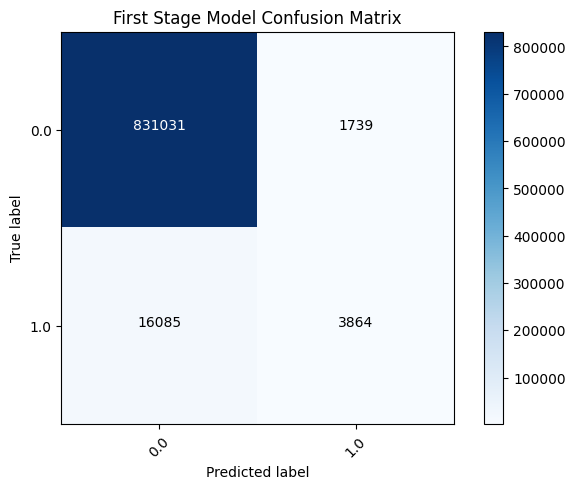

In [12]:
df.loc[df["binary_label"].notnull(), "first_stage_preds"] = first_stage_output[
    "train_preds"
]
df.loc[df["binary_label"].isnull(), "first_stage_preds"] = first_stage_output[
    "test_preds"
]

train_auc = roc_auc_score(
    y_true=df.loc[df["binary_label"].notnull(), "binary_label"],
    y_score=df.loc[df["binary_label"].notnull(), "first_stage_preds"],
)

train_f1 = f1_score(
    y_true=df.loc[df["binary_label"].notnull(), "binary_label"],
    y_pred=np.where(
        df.loc[df["binary_label"].notnull(), "first_stage_preds"] > 0.5, 1, 0
    ),
)

# Train AUC
print(f"Train AUC: {train_auc:.5f}")

# Train F1
print(f"Train F1: {train_f1:.5f}")

# Train Confusion Matrix
train_cm = confusion_matrix(
    y_true=df.loc[df["binary_label"].notnull(), "binary_label"],
    y_pred=np.where(
        df.loc[df["binary_label"].notnull(), "first_stage_preds"] > 0.5, 1, 0
    ),
)
plot_confusion_matrix(
    cm=train_cm,
    classes=sorted(df["binary_label"].dropna().unique()),
    title="First Stage Model Confusion Matrix",
)

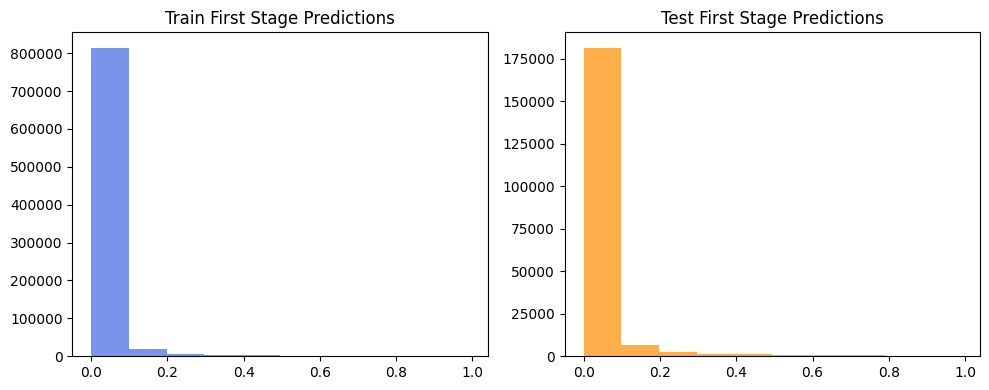

In [13]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(
    df.loc[df["binary_label"].notnull(), "first_stage_preds"],
    color="royalblue",
    alpha=0.7,
)
plt.title("Train First Stage Predictions", size=12)

plt.subplot(1, 2, 2)
plt.hist(
    df.loc[df["binary_label"].isnull(), "first_stage_preds"],
    color="darkorange",
    alpha=0.7,
)
plt.title("Test First Stage Predictions", size=12)

plt.tight_layout()
plt.show()

best score: 0.4201429760845224
best threshold: 0.25


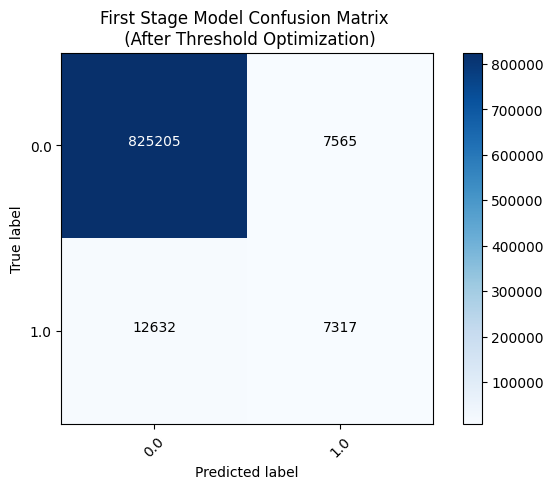

In [14]:
if config.thr_opt == True:

    # Threshold Optimization
    thr_range = np.arange(0.25, 0.75, 0.005)
    score_list = list()

    for thr in thr_range:
        score_list.append(
            f1_score(
                y_true=df.loc[df["binary_label"].notnull(), "binary_label"],
                y_pred=np.where(
                    df.loc[df["binary_label"].notnull(), "first_stage_preds"] > thr,
                    1,
                    0,
                ),
            )
        )

    best_score = np.max(score_list)
    best_thr = thr_range[np.argmax(score_list)]

    print(f"best score: {best_score}")
    print(f"best threshold: {best_thr}")

    # Train Confusion Matrix (After Threshold Optimization)
    train_cm = confusion_matrix(
        y_true=df.loc[df["binary_label"].notnull(), "binary_label"],
        y_pred=np.where(
            df.loc[df["binary_label"].notnull(), "first_stage_preds"] > best_thr, 1, 0
        ),
    )
    plot_confusion_matrix(
        cm=train_cm,
        classes=sorted(df["binary_label"].dropna().unique()),
        title="First Stage Model Confusion Matrix \n (After Threshold Optimization)",
    )

    df.loc[df["first_stage_preds"] > best_thr, "first_stage_preds_label"] = 1
    df.loc[df["first_stage_preds"] <= best_thr, "first_stage_preds_label"] = 0

else:
    df.loc[df["first_stage_preds"] > 0.5, "first_stage_preds_label"] = 1
    df.loc[df["first_stage_preds"] <= 0.5, "first_stage_preds_label"] = 0

# 7. Second Stage Model - Multiclass Classification

In [15]:
X = (
    df.loc[df["binary_label"] == 1]
    .drop(
        columns=[
            "label",
            "binary_label",
            "first_stage_preds",
            "first_stage_preds_label",
        ],
        axis=1,
    )
    .reset_index(drop=True)
)

y = df.loc[df["binary_label"] == 1, "label"].reset_index(drop=True)

enc = LabelEncoder()
y = pd.Series(enc.fit_transform(y))

X_test = (
    df.loc[(df["label"].isnull()) & (df["first_stage_preds_label"] == 1)]
    .drop(
        columns=[
            "label",
            "binary_label",
            "first_stage_preds",
            "first_stage_preds_label",
        ],
        axis=1,
    )
    .reset_index(drop=True)
)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")

X shape: (19949, 102)
y shape: (19949,)
X_test shape: (5863, 102)


In [16]:
class_weights_dict = determine_coeffs(df.loc[df["label"].notnull()])

class_weights = {
    i: class_weights_dict[enc.inverse_transform(np.array([i]))[0]]
    for i in sorted(y.unique())
}

print(f"class weights: {class_weights}")

class weights: {0: 0.038554833858603386, 1: 0.032866754829034756, 2: 0.27910538041604, 3: 0.1812533461577538, 4: 0.011393645341514, 5: 0.2952464144641965, 6: 0.1614324927571035}


n folds: 10
========================================| Fold 1 |========================================
train: (17954, 102)
val: (1995, 102)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 200 rounds
[200]	valid_0's multi_logloss: 0.973897
[400]	valid_0's multi_logloss: 0.903056
[600]	valid_0's multi_logloss: 0.885997
Early stopping, best iteration is:
[590]	valid_0's multi_logloss: 0.885755
Fold log_loss: 0.88575
Elapsed: 37.15 seconds

========================================| Fold 2 |========================================
train: (17954, 102)
val: (1995, 102)
Training until validation scores don't improve for 200 rounds
[200]	valid_0's multi_logloss: 0.963742
[400]	valid_0's multi_logloss: 0.895041
[600]	valid_0's multi_logloss: 0.880717
Early stopping, best iteration is:
[581]	valid_0's multi_logloss: 0.880235
Fold log_loss: 0.88023
Elapsed: 31.92 seconds

========================================| Fold 3 |========================================
train: (17954, 102)
val: (1995, 102)
Training until validation scores don't improve for 200 rounds
[200]	valid_0's multi_logloss: 0.97859
[400]	valid_0's multi_logloss: 0.90

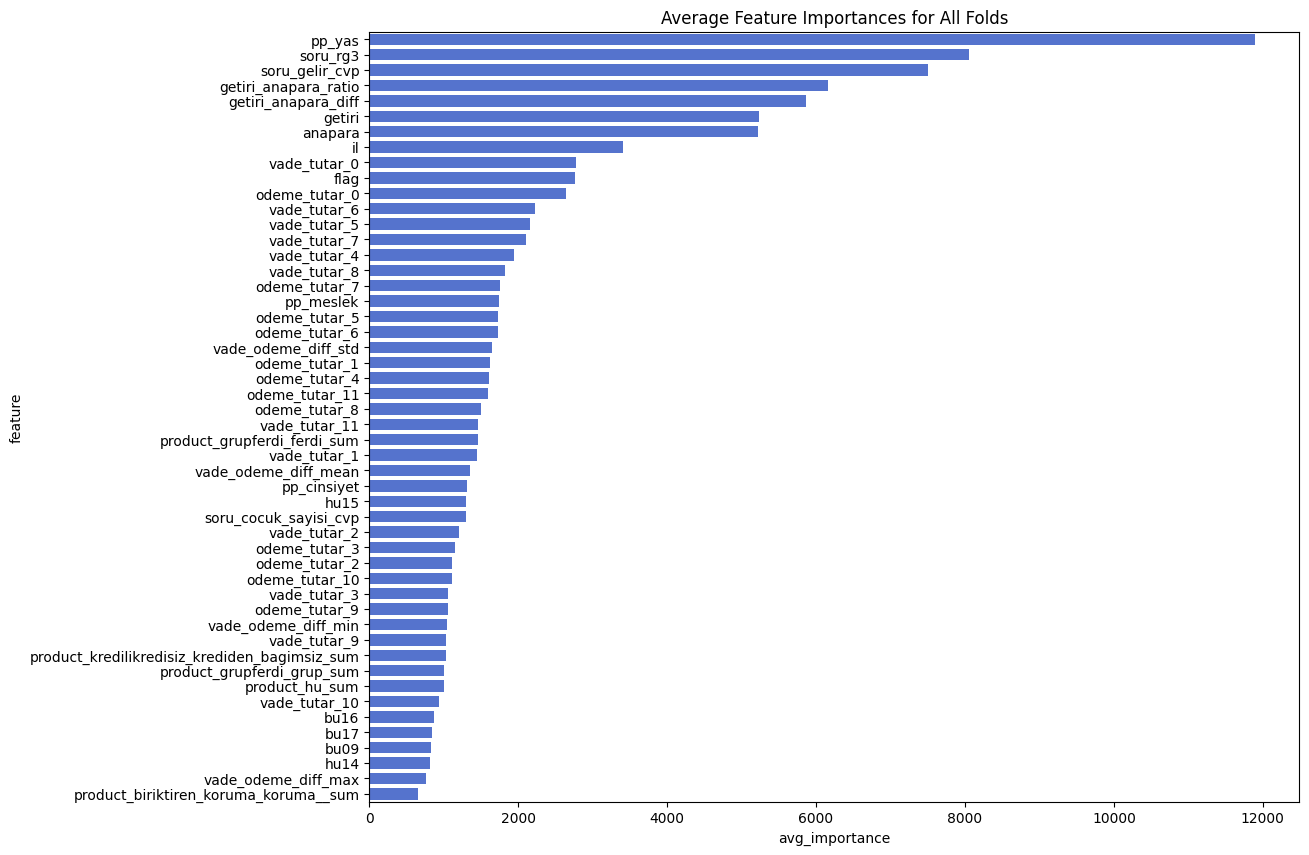

In [17]:
second_stage_model = lgb.LGBMClassifier(
    **{
        "boosting_type": "gbdt",
        "learning_rate": 0.032,
        "random_state": config.seed,
        "max_depth": 8,
        "objective": "multiclass",
        "num_classes": y.nunique(),
        "verbose": -1,
        "n_estimators": 5000,
        "device": "gpu",
        "class_weight": class_weights,
    }
)

second_stage_train_params = {
    "callbacks": [lgb.log_evaluation(200), lgb.early_stopping(200)]
}

second_stage_output = clf_trainer(
    model=second_stage_model,
    X=X,
    X_test=X_test,
    y=y,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=config.seed),
    train_params=second_stage_train_params,
    plot_importances=True,
    eval_metric="log_loss",
)

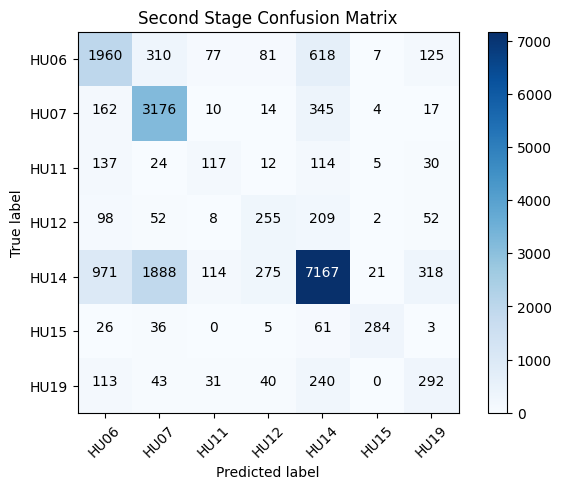

In [18]:
second_stage_train_preds = second_stage_output["train_preds"]
second_stage_test_preds = second_stage_output["test_preds"]

second_stage_train_pred_labels = enc.inverse_transform(
    (pd.Series([np.argmax(i) for i in second_stage_train_preds]))
)

second_stage_test_pred_labels = enc.inverse_transform(
    (pd.Series([np.argmax(i) for i in second_stage_test_preds]))
)

plot_confusion_matrix(
    cm=confusion_matrix(
        y_true=y, y_pred=(pd.Series([np.argmax(i) for i in second_stage_train_preds]))
    ),
    classes=sorted(pd.Series(second_stage_train_pred_labels).unique()),
    title="Second Stage Confusion Matrix",
)

In [19]:
df.loc[df["binary_label"] == 1, "second_stage_preds"] = second_stage_train_pred_labels

df.loc[
    (df["label"].isnull()) & (df["first_stage_preds_label"] == 1), "second_stage_preds"
] = second_stage_test_pred_labels

df["first_stage_preds_label"] = df["first_stage_preds_label"].apply(
    lambda x: "UA" if x == 0 else np.nan
)

df["final_pred"] = df["first_stage_preds_label"]

df.loc[df["second_stage_preds"].notnull(), "final_pred"] = df.loc[
    df["second_stage_preds"].notnull(), "second_stage_preds"
]

df.head()

,label,flag,pp_cinsiyet,pp_yas,pp_meslek,pp_musteri_segmenti,pp_uyruk,il,soru_medeni_hal_cvp,soru_egitim_cvp,...,vade_odeme_diff_mean,vade_odeme_diff_max,vade_odeme_diff_min,vade_odeme_diff_std,getiri_anapara_ratio,getiri_anapara_diff,first_stage_preds,first_stage_preds_label,second_stage_preds,final_pred
0,UA,2,1,42.083333,Öğretmen,105,1,34.0,Single,(Diğer),...,0.000000,0,0,0.000000,0.049736,2522,0.002789,UA,NaN,UA
1,UA,2,1,74.083333,Emekli,102,1,20.0,Married,İlköğretim,...,159.500000,1914,0,552.524208,1.197395,-12425,0.006719,UA,NaN,UA
2,HU19,2,1,48.166667,Muhasebe,104,1,6.0,Single,Lisans,...,0.000000,0,0,0.000000,0.700205,6874,0.065541,UA,HU07,HU07
3,UA,1,1,54.000000,Diğer,106,1,34.0,Married,Lise,...,-395.333333,-306,-574,131.954078,2.792135,-319,0.000579,UA,NaN,UA
4,UA,5,1,40.583333,İşçi,103,1,77.0,Married,Lisans,...,-273.916667,0,-459,190.467587,0.835269,227,0.022108,UA,NaN,UA


In [20]:
df["label"].value_counts()

label
UA      832770
HU14     10754
HU07      3728
HU06      3178
HU19       759
HU12       676
HU11       439
HU15       415
Name: count, dtype: int64

In [21]:
df.loc[df["label"].isnull(), "final_pred"].value_counts()

final_pred
UA      189768
HU14      3097
HU07      1523
HU06       497
HU19       374
HU11       195
HU12       124
HU15        53
Name: count, dtype: int64

# 8. Saving Submission

In [22]:
sample_submission = pd.read_csv(config.sample_submission_path)

sample_submission["LABEL"] = df.loc[df["label"].isnull(), "final_pred"].values.tolist()

sample_submission.head()

,MUSTERI_ID,LABEL
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,UA
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,UA
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,UA
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,UA
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,UA


In [23]:
sample_submission.isnull().sum()

MUSTERI_ID    0
LABEL         0
dtype: int64

In [24]:
sample_submission.to_csv("submission.csv", index=False)